In [1]:
# Import stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Our package
import chillmax as cm

import scipy
from scipy.signal import chirp, find_peaks, peak_widths

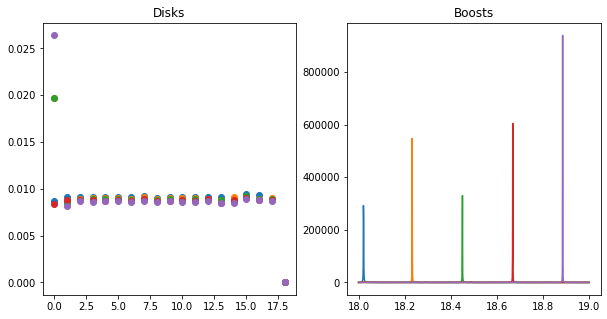

In [2]:
def from_jld(i):
    import h5py
    f = h5py.File('datasets/frequency_scaling_{}_{}.jld2'.format(18+i, 19+i), 'r')
    return f['spacs'][()]
    
_base_configs = from_jld(0)[::10]  # every 10th
base_configs = np.zeros((_base_configs.shape[0], _base_configs.shape[1] + 1))
base_configs = _base_configs[:, :-1]
base_configs[:, -1] = np.zeros(base_configs.shape[0])

# Let's inspect what they look like and what boost factors they give
# Plots inputs and outputs
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs = axs.flatten()
freqs = np.linspace(18, 19, 1000)
for i, cfg in enumerate(base_configs):
    axs[0].scatter(np.arange(len(cfg)), cfg, label=i)
    axs[1].plot(freqs, cm.sim.boost(freqs*1e9, spacings=cfg), label=i)

axs[0].set_title("Disks")
axs[1].set_title("Boosts");

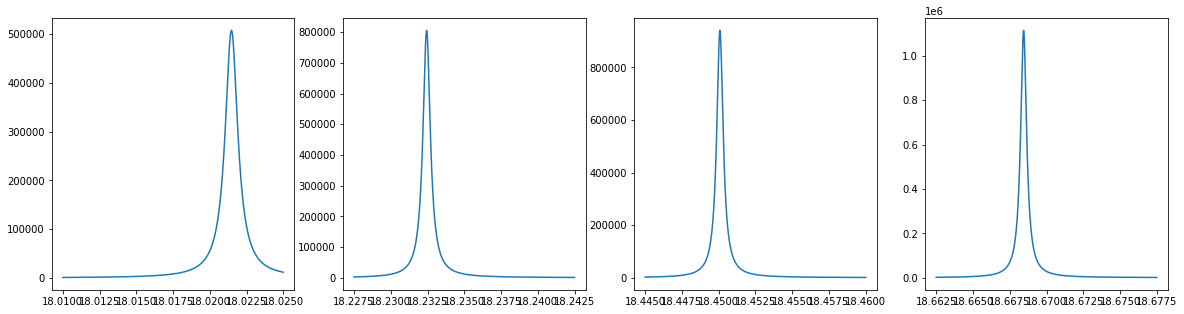

In [3]:
# Zoom in
fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs = axs.flatten()
for i, (cfg, fbase) in enumerate(zip(base_configs, np.linspace(18.01, 18.88, len(base_configs)))):    
    freqs = np.linspace(fbase, fbase+0.015, 1000)
    axs[i].plot(freqs, cm.sim.boost(freqs*1e9, spacings=cfg))
    if i == 3: break


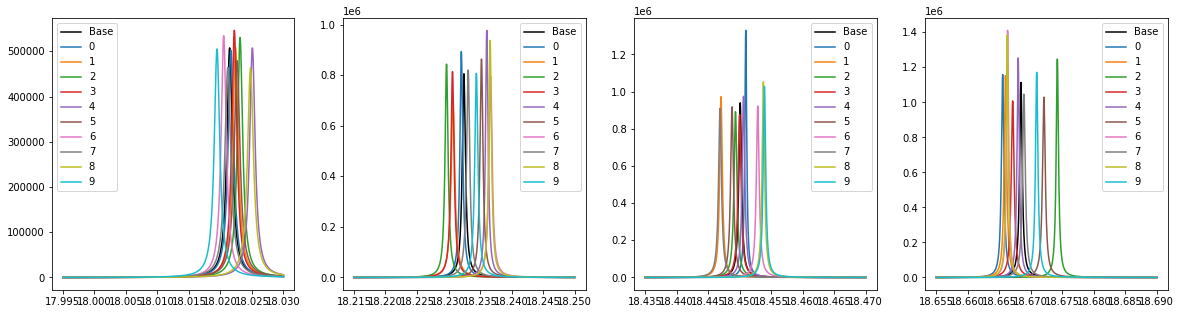

In [4]:
N = 100 # Number of variations
frac = 0.001 # Variation strength
generated = []

# Generate
fig, axs = plt.subplots(1, 4, figsize=(20,5))
axs = axs.flatten()
for i, (cfg, fbase) in enumerate(zip(base_configs, np.linspace(18, 18.88, len(base_configs)))):
    _gen_cfg = np.tile(cfg, (N,1)) * np.random.uniform(1-frac,1+frac, (N, len(cfg)))
    
    freqs = np.linspace(fbase-0.005, fbase+0.03, 1000)
    axs[i].plot(freqs, cm.sim.boost(freqs*1e9, spacings=cfg), label="Base", color='black')
    for j, row in enumerate(_gen_cfg):
        axs[i].plot(freqs, cm.sim.boost(freqs*1e9, spacings=row), label=j)
        if j > 8: break
    axs[i].legend()
    
    generated.append(_gen_cfg)
        
    if i == 3: break


array([[18.00701201, 18.05304805]])

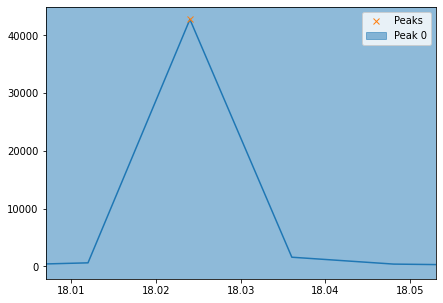

In [5]:
cfg = generated[0][10]  

def get_spans(cfg, freq=(14, 26), plot=False):
    if len(freq) != 2:
        freqs = freq # passed linspace i guess
    else:
        freqs = np.linspace(freq[0], freq[1], 1000)
        
    boost = cm.sim.boost(freqs*1e9, spacings=cfg)
    
    if plot:
        fig, axs = plt.subplots(figsize=(7,5))
        axs.plot(freqs, boost)
    
    peaks, _ = find_peaks(boost, prominence=np.max(boost)*0.1)
    results_full = peak_widths(boost, peaks, rel_height=0.98)

    if plot: 
        axs.plot(freqs[peaks], boost[peaks], "x", label="Peaks")


    def find(peak, freqs):
        rmin, rmax = np.floor(peak[0]).astype(int), np.ceil(peak[1]).astype(int)
        fmin, fmax = freqs[rmin], freqs[rmax]
        scale = 0.1
        size = fmax - fmin
        extra = max(0.005, size * 0.08)
        #print(extra)
        return fmin - extra, fmax + extra

    peaks = np.array(results_full[2:]).T
    spans = []
    for i, peak in enumerate(peaks):
        if plot:
            axs.axvspan(*find(peak, freqs), alpha=0.5, label=f'Peak {i}', color=f'C{i}')
        spans.append(find(peak, freqs))
        
    np.min(np.array(spans))
    
    if plot:
        axs.legend()
        plt.xlim(np.min(np.array(spans)), np.max(np.array(spans)))
    return np.array(spans)
    
get_spans(cfg, plot=True)

In [6]:
def get_spans_overlap(spans):
    sorted_by_lower_bound = sorted(spans, key=lambda tup: tup[0])
    merged = []

    for higher in sorted_by_lower_bound:
        if not merged:
            merged.append(higher)
        else:
            lower = merged[-1]
            # test for intersection between lower and higher:
            # we know via sorting that lower[0] <= higher[0]
            if higher[0] <= lower[1]:
                upper_bound = max(lower[1], higher[1])
                merged[-1] = (lower[0], upper_bound)  # replace by merged interval
            else:
                merged.append(higher)
    return np.array(merged)

get_spans_overlap(get_spans(cfg))

array([[18.00701201, 18.05304805]])

(17.8, 18.2)

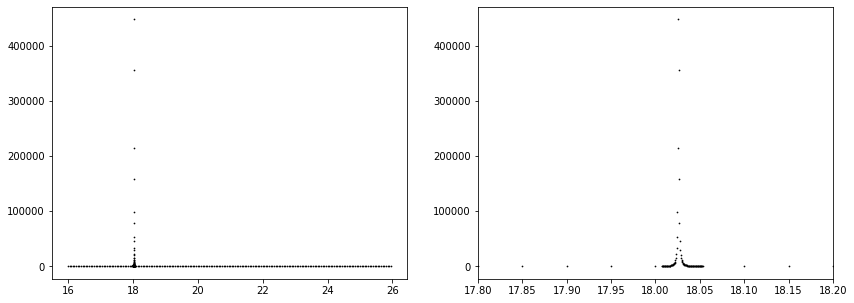

In [7]:
def find_sampling(spans):
    pts = []
    for i, span in enumerate(spans):
        pts.append(np.linspace(*span, 100))
    pts.append(np.arange(16, 26, 0.05))
    return np.sort(np.hstack(pts), kind='heapsort')

def find_split_sampling(spans, cfgs):
    pts = []
    for i, span in enumerate(spans):
        pts.append(np.linspace(*span, 200))
    cfgs = np.tile(cfgs, (len(pts), 1))
    return np.array(pts), cfgs
            
xar = find_sampling(get_spans_overlap(get_spans(cfg)))

fig, axs = plt.subplots(1,2, figsize=(14, 5))
axs[0].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')

axs[1].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
axs[1].set_xlim(17.8, 18.2)

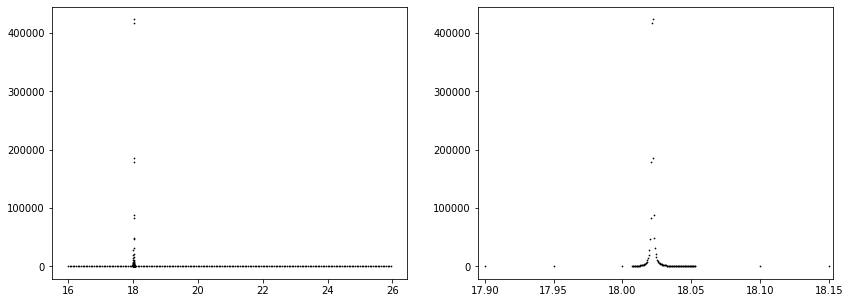

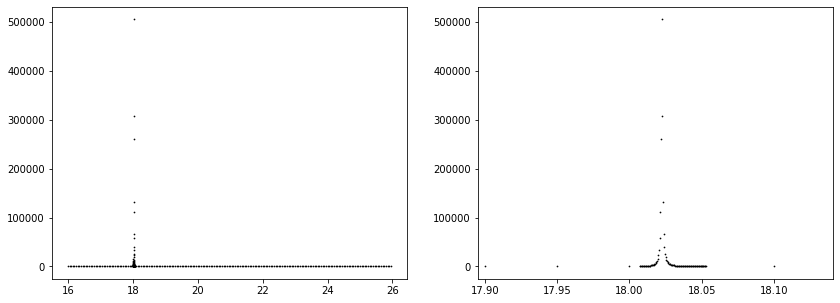

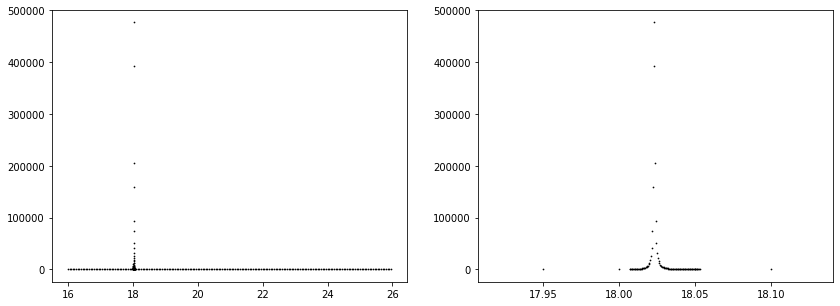

In [8]:
for i, cfg in enumerate(generated[0][:3]):
    #spans = get_spans_overlap(get_spans(cfg)) # span overlap can result in low sampling in wide peaks
    spans = get_spans(cfg)
    #xar = find_sampling(spans)
    fig, axs = plt.subplots(1,2, figsize=(14, 5))
    axs[0].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
    axs[1].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
    
    
    axs[1].set_xlim(np.min(spans)-0.1, np.max(spans)+0.1)

### Read some actual peaks


In [9]:
#!wget -O data_input.csv https://www.dropbox.com/s/g9xvk71iio3rcmu/single_input?dl=0
dfi = pd.read_csv('data_input.csv')
X = dfi.to_numpy()


dfo = pd.read_csv('data_output.csv')
dfo[:6]


,2.28e10,2.28025e10,2.2805e10,2.28075e10,2.281e10,2.28125e10,2.2815e10,2.28175e10,2.282e10,2.28225e10,...,2.29275e10,2.293e10,2.29325e10,2.2935e10,2.29375e10,2.294e10,2.29425e10,2.2945e10,2.29475e10,2.295e10
0,112.837188,109.988434,106.134855,101.076908,94.595033,86.460540,76.460702,64.451038,50.459696,34.892642,...,2530.836075,2261.083019,2029.781670,1830.394376,1657.627710,1507.180224,1375.541747,1259.834608,1157.688320,1067.140633
1,327.283486,339.060828,351.193185,363.545106,375.922717,388.052728,399.554484,409.903165,418.382082,424.022760,...,1629.599444,1471.268993,1334.888690,1216.619880,1113.420476,1022.856042,942.960802,872.134130,809.062601,752.660679
2,47.039006,40.060751,32.127870,23.435324,14.465403,6.227775,0.699967,1.652486,16.234075,58.107446,...,2257.272207,2032.000113,1836.923530,1667.201025,1518.861950,1388.639366,1273.835289,1172.212551,1081.908236,1001.364368
3,116.786545,114.717253,112.104138,108.819025,104.716629,99.634186,93.393477,85.807612,76.696807,65.921221,...,4498.524795,3959.173068,3498.341474,3104.151169,2766.182138,2475.516958,2224.636420,2007.254689,1818.140876,1652.949917
4,220.516834,226.546225,232.489322,238.201355,243.491296,248.107634,251.720212,253.897440,254.078560,251.541912,...,2060.598038,1834.649833,1643.469088,1480.392441,1340.255310,1219.010444,1113.453625,1021.023890,939.656282,867.672070
5,128.795965,127.732945,126.113414,123.797188,120.620988,116.396137,110.907862,103.918232,95.176376,84.443097,...,3707.185479,3264.673360,2890.117731,2571.584623,2299.344339,2065.488785,1863.592204,1688.425078,1535.719551,1401.980104


NameError: name 'y' is not defined

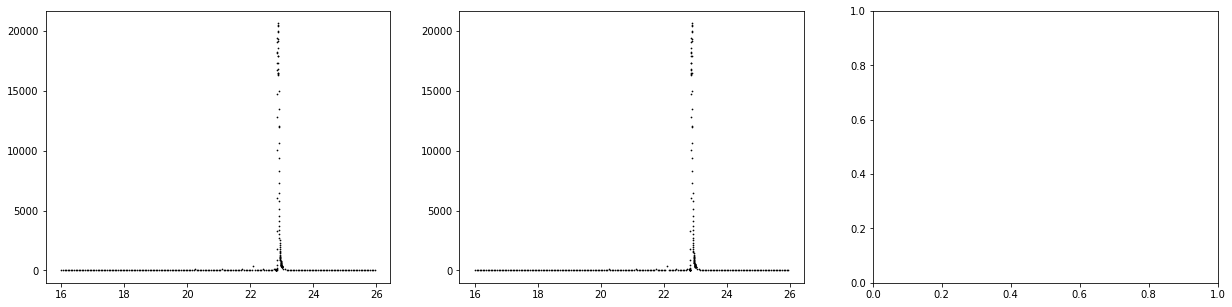

In [11]:
for i, cfg in enumerate(X[:3]):
    #spans = get_spans_overlap(get_spans(cfg)) # span overlap can result in low sampling in wide peaks
    spans = get_spans(cfg)
    xar = find_sampling(spans)
    # print(xar)

    fig, axs = plt.subplots(1,3, figsize=(21, 5))
    axs[0].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
    
    def wrap(_freqs, test_dist):
        return np.abs(cm.Analytical1D.disk_system(_freqs,tand=0.,num_disk=19,spacings=test_dist,mirror=True,disk_thickness=0.001,disk_epsilon=24.)[1])**2

    axs[1].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')
    #axs[1].scatter(xar*1e9, wrap(xar, cfg), s=0.5, c='black')
    axs[1].scatter(freqs/1e9, y[i], s=0.5, c='red')
    #axs[1].set_xlim(np.min(spans)-0.1, np.max(spans)+0.1)
    
    axs[2].scatter(freqs/1e9, y[i], s=0.5, c='red')
    axs[2].set_xlim(*axs[2].get_xlim())
    axs[2].scatter(xar, cm.sim.boost(xar*1e9, spacings=cfg), s=0.5, c='black')